In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import censusdata
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [2]:
areas = gpd.read_file("data/Boundaries - Neighborhoods.geojson")

In [3]:
block_groups = gpd.read_file("data/Boundaries - Census Blocks - 2010.geojson")
block_groups["blockgroup"] = block_groups["geoid10"].str[0:12]
block_groups = block_groups[["geometry", "blockgroup"]]
block_groups = block_groups.dissolve(by="blockgroup")

block_groups = gpd.sjoin(block_groups, areas, how="left", op='intersects')
block_groups = block_groups.dissolve(by='blockgroup', aggfunc='first')

block_groups = block_groups[["geometry", "pri_neigh"]].reset_index()
block_groups.head()

,blockgroup,geometry,pri_neigh
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",Rogers Park
1,170310101002,"POLYGON ((-87.66950 42.01936, -87.66963 42.019...",Rogers Park
2,170310101003,"POLYGON ((-87.66681 42.01924, -87.66780 42.019...",Rogers Park
3,170310102011,"POLYGON ((-87.68234 42.01250, -87.68268 42.012...",Rogers Park
4,170310102012,"POLYGON ((-87.67972 42.01392, -87.68003 42.013...",Rogers Park


In [4]:
bus_routes = gpd.read_file("data/CTA_BusRoutes.kml", driver='KML')
rides = pd.read_csv("data/CTA_-_Ridership_-_Bus_Routes_-_Monthly_Day-Type_Averages___Totals.csv")

route_rides = bus_routes.merge(rides, left_on="Name", right_on="route", how="outer")

route_rides["year"] = pd.to_datetime(route_rides["Month_Beginning"]).dt.year
route_rides["month"] = pd.to_datetime(route_rides["Month_Beginning"]).dt.month

route_rides = route_rides.dropna(subset=["geometry"])

In [5]:
# Pull ACS data 
census_tables = {
    'GEO_ID': 'GEO_ID',
    'B02001_001E': 'Population',
    'B01002_001E': 'Median Age',
    'B19013_001E': 'Median Income'}

acs_blkgrp_2018 = censusdata.download("acs5", 
                              2018, 
                              censusdata.censusgeo([("state", "17"), 
                                                    ("county", "031"),
                                                    ("tract", "*"),
                                                    ("block group", "*")]), 
                              list(census_tables.keys()))

# Rename columns 
acs_blkgrp_2018.rename(columns=census_tables, inplace=True)

In [6]:
acs_blkgrp_2017 = censusdata.download("acs5", 
                              2017, 
                              censusdata.censusgeo([("state", "17"), 
                                                    ("county", "031"),
                                                    ("tract", "*"),
                                                    ("block group", "*")]), 
                              list(census_tables.keys()))
acs_blkgrp_2017.rename(columns=census_tables, inplace=True)

acs_blkgrp_2016 = censusdata.download("acs5", 
                              2016, 
                              censusdata.censusgeo([("state", "17"), 
                                                    ("county", "031"),
                                                    ("tract", "*"),
                                                    ("block group", "*")]), 
                              list(census_tables.keys()))
acs_blkgrp_2016.rename(columns=census_tables, inplace=True)

acs_blkgrp_2015 = censusdata.download("acs5", 
                              2015, 
                              censusdata.censusgeo([("state", "17"), 
                                                    ("county", "031"),
                                                    ("tract", "*"),
                                                    ("block group", "*")]), 
                              list(census_tables.keys()))
acs_blkgrp_2015.rename(columns=census_tables, inplace=True)

acs_blkgrp_2014 = censusdata.download("acs5", 
                              2014, 
                              censusdata.censusgeo([("state", "17"), 
                                                    ("county", "031"),
                                                    ("tract", "*"),
                                                    ("block group", "*")]), 
                              list(census_tables.keys()))
acs_blkgrp_2014.rename(columns=census_tables, inplace=True)


In [7]:
for df, year in [(acs_blkgrp_2018, 2018),
                (acs_blkgrp_2017, 2017),
                (acs_blkgrp_2016, 2016),
                (acs_blkgrp_2015, 2015),
                (acs_blkgrp_2014, 2014)]:
    df["year"] = year

In [8]:
blkgrp_data = pd.concat([acs_blkgrp_2018,
                         acs_blkgrp_2017,
                         acs_blkgrp_2016,
                         acs_blkgrp_2015,
                         acs_blkgrp_2014])

blkgrp_data["blockgroup"] = blkgrp_data["GEO_ID"].str[-12:]
blkgrp_data["tract"] = blkgrp_data["GEO_ID"].str[-12:-1]
blkgrp_data.head()

,GEO_ID,Population,Median Age,Median Income,year,blockgroup,tract
"Block Group 1, Census Tract 8088, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:808800> block group:1",1500000US170318088001,1738,39.2,96111.0,2018,170318088001,17031808800
"Block Group 2, Census Tract 8088, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:808800> block group:2",1500000US170318088002,1994,47.3,173646.0,2018,170318088002,17031808800
"Block Group 2, Census Tract 8092, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:809200> block group:2",1500000US170318092002,1210,34.7,51136.0,2018,170318092002,17031809200
"Block Group 4, Census Tract 8092, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:809200> block group:4",1500000US170318092004,945,37.4,-666666666.0,2018,170318092004,17031809200
"Block Group 1, Census Tract 8092, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:809200> block group:1",1500000US170318092001,847,37.7,48019.0,2018,170318092001,17031809200


In [9]:
acs_2014 = pd.read_csv("data/ACS/ACSDP5Y2014.DP03_data_with_overlays_2020-05-31T160939.csv", low_memory=False)
acs_2015 = pd.read_csv("data/ACS/ACSDP5Y2015.DP03_data_with_overlays_2020-05-31T160939.csv", low_memory=False)
acs_2016 = pd.read_csv("data/ACS/ACSDP5Y2016.DP03_data_with_overlays_2020-05-31T160939.csv", low_memory=False)
acs_2017 = pd.read_csv("data/ACS/ACSDP5Y2017.DP03_data_with_overlays_2020-05-31T160939.csv", low_memory=False)
acs_2018 = pd.read_csv("data/ACS/ACSDP5Y2018.DP03_data_with_overlays_2020-05-31T160939.csv", low_memory=False)

In [10]:
acs_2014 = acs_2014[["GEO_ID", "DP03_0021E", "DP03_0021PE"]]
acs_2015 = acs_2015[["GEO_ID", "DP03_0021E", "DP03_0021PE"]]
acs_2016 = acs_2016[["GEO_ID", "DP03_0021E", "DP03_0021PE"]]
acs_2017 = acs_2017[["GEO_ID", "DP03_0021E", "DP03_0021PE"]]
acs_2018 = acs_2018[["GEO_ID", "DP03_0021E", "DP03_0021PE"]]

In [11]:
acs_2014["year"] = 2014
acs_2015["year"] = 2015
acs_2016["year"] = 2016
acs_2017["year"] = 2017
acs_2018["year"] = 2018

In [12]:
tract_data = pd.concat([acs_2014, acs_2015, acs_2016,
                        acs_2017, acs_2018])

tract_data = tract_data.rename(columns={"DP03_0021E": "WorkTransitCount",
                                       "DP03_0021PE": "WorkTransitPercent"})

tract_data["tract"] = tract_data["GEO_ID"].str[-11:]

In [13]:
census_df = pd.merge(blkgrp_data, tract_data, on=["tract", "year"])
census_df = census_df[["year", "blockgroup", "tract",
                       "Population", "Median Age",
                      "Median Income",
                      "WorkTransitCount",
                      "WorkTransitPercent"]]

census_df.loc[census_df["Median Income"] < 0, "Median Income"] = None
census_df.loc[census_df["Median Age"] < 0, "Median Age"] = None
census_df.loc[census_df["WorkTransitPercent"] < "0", "WorkTransitPercent"] = 0.0

census_df["WorkTransitCount"] = pd.to_numeric(census_df["WorkTransitCount"])
census_df["WorkTransitPercent"] = pd.to_numeric(census_df["WorkTransitPercent"])

In [14]:
census_df[census_df["blockgroup"] == "170318361002"]

,year,blockgroup,tract,Population,Median Age,Median Income,WorkTransitCount,WorkTransitPercent
2979,2018,170318361002,17031836100,75,25.2,NaN,78,11.4
7147,2017,170318361002,17031836100,90,25.1,NaN,92,13.0
10278,2016,170318361002,17031836100,84,25.1,NaN,189,26.8
12537,2015,170318361002,17031836100,82,25.3,65234.0,222,34.2
19808,2014,170318361002,17031836100,5,NaN,NaN,243,37.8


In [15]:
# merge census_df with block_groups
block_groups = block_groups.merge(census_df, on="blockgroup")

In [16]:
# add routes to block groups & ridership estimates
route_blockgroups = gpd.sjoin(route_rides, block_groups, how="left", op='intersects')

In [17]:
route_blockgroups = route_blockgroups[route_blockgroups["year_right"] == route_blockgroups["year_left"]]

In [18]:
route_blockgroups = route_blockgroups[["route", "MonthTotal", "year_left",
                                       "month", "blockgroup", "Population"]]

route_pop_total = route_blockgroups.groupby(["year_left",
                                             "month",
                                             "route"])["Population"].sum().reset_index()
route_pop_total = route_pop_total.rename(columns={"Population" : "TotalPop"})

route_blockgroups = route_blockgroups.merge(route_pop_total, on=["year_left", "month", "route"]).reset_index()

route_blockgroups["PercentTotal"] = route_blockgroups["Population"] / route_blockgroups["TotalPop"]

route_blockgroups["MonthTotal"] = \
    route_blockgroups["MonthTotal"] * route_blockgroups["PercentTotal"]

route_blockgroups.head()

,index,route,MonthTotal,year_left,month,blockgroup,Population,TotalPop,PercentTotal
0,0,68,3190.695839,2014,1,170310902003,1714,15334,0.111778
1,1,68,3427.112626,2014,1,170310902004,1841,15334,0.120060
2,2,68,1749.856528,2014,1,170311001003,940,15334,0.061302
3,3,68,1461.316356,2014,1,170311001004,785,15334,0.051193
4,4,68,2769.985653,2014,1,170311002003,1488,15334,0.097039


In [19]:
route_aggs = route_blockgroups.groupby(["year_left",
                                        "month",
                                        "blockgroup"]).agg({'route': "count",
                                                            'MonthTotal': 'sum'})


route_aggs = route_aggs.reset_index()
route_aggs = route_aggs.rename(columns={'route': "count_of_routes",
                                        "year_left": "year"})
route_aggs.head()

,year,month,blockgroup,count_of_routes,MonthTotal
0,2014,1,170310101002,2,11165.613536
1,2014,1,170310101003,2,16422.604040
2,2014,1,170310102012,3,86703.375137
3,2014,1,170310102021,6,44325.096788
4,2014,1,170310102022,1,5223.021706


In [20]:
block_groups = block_groups.merge(route_aggs, on=["blockgroup", "year"], how="inner")

In [21]:
# rearranging and simplifying
block_groups = block_groups[["blockgroup", "pri_neigh", "year", "month",
                             "Population", "Median Income", "Median Age",
                             "WorkTransitCount", "WorkTransitPercent",
                             "count_of_routes", "MonthTotal",
                             "geometry"]]


block_groups.shape

(115900, 12)

In [22]:
block_groups["prior_year"] = block_groups["year"] - 1

last_year = block_groups[["blockgroup", "year", "month",
                          "Population", "Median Income", "Median Age",
                          "WorkTransitCount", "WorkTransitPercent",
                          "count_of_routes"]]

last_year.shape

(115900, 9)

In [23]:
last_year = last_year.merge(block_groups, how="inner", left_on=["blockgroup", "month", "year"],
                           right_on=["blockgroup", "month", "prior_year"])
last_year.shape

(92656, 20)

In [24]:
last_year["pop_change"] = \
    (last_year["Population_y"] - last_year["Population_x"]) / last_year["Population_x"]

last_year["income_change"] = \
    (last_year["Median Income_y"] - last_year["Median Income_x"]) / last_year["Median Income_x"]

last_year["age_change"] = \
    (last_year["Median Age_y"] - last_year["Median Age_x"]) / last_year["Median Age_x"]

last_year["wt_count_change"] = \
    (last_year["WorkTransitCount_y"] - last_year["WorkTransitCount_x"]) / last_year["WorkTransitCount_x"]

last_year["wt_perc_change"] = \
    (last_year["WorkTransitPercent_y"] - last_year["WorkTransitPercent_x"]) / last_year["WorkTransitPercent_x"]

last_year["rt_count_change"] = \
    (last_year["count_of_routes_y"] - last_year["count_of_routes_x"]) / last_year["count_of_routes_x"]

In [25]:
#simplifying
last_year = last_year[["pop_change", "income_change", "age_change",
                      "wt_count_change", "wt_perc_change",
                      "rt_count_change", "blockgroup",
                      "month", "year_y"]]

# updating "inf" resulting from NaN/NaN calculations
last_year.loc[last_year["pop_change"] > 100, :] = None

In [26]:
block_groups = block_groups.merge(last_year, how="inner",
                                  left_on=["blockgroup", "year", "month"],
                                  right_on=["blockgroup", "year_y", "month"])

In [27]:
block_groups = block_groups[["blockgroup", "year", "month", "prior_year",
                             "pri_neigh", "Population", "pop_change",
                             "Median Income", "income_change",
                             "Median Age", "age_change",
                             "WorkTransitCount", "wt_count_change",
                             "WorkTransitPercent", "wt_perc_change",
                             "count_of_routes", "rt_count_change",
                             "MonthTotal", "geometry"]]

block_groups.head(2)

,blockgroup,year,month,prior_year,pri_neigh,Population,pop_change,Median Income,income_change,Median Age,age_change,WorkTransitCount,wt_count_change,WorkTransitPercent,wt_perc_change,count_of_routes,rt_count_change,MonthTotal,geometry
0,170310101002,2018,1,2017,Rogers Park,2197,0.012442,21222.0,0.024426,31.4,0.003195,1087,-0.101653,43.9,-0.132411,2,0.0,13420.077747,"POLYGON ((-87.66950 42.01936, -87.66963 42.019..."
1,170310101002,2018,2,2017,Rogers Park,2197,0.012442,21222.0,0.024426,31.4,0.003195,1087,-0.101653,43.9,-0.132411,2,0.0,12733.663576,"POLYGON ((-87.66950 42.01936, -87.66963 42.019..."


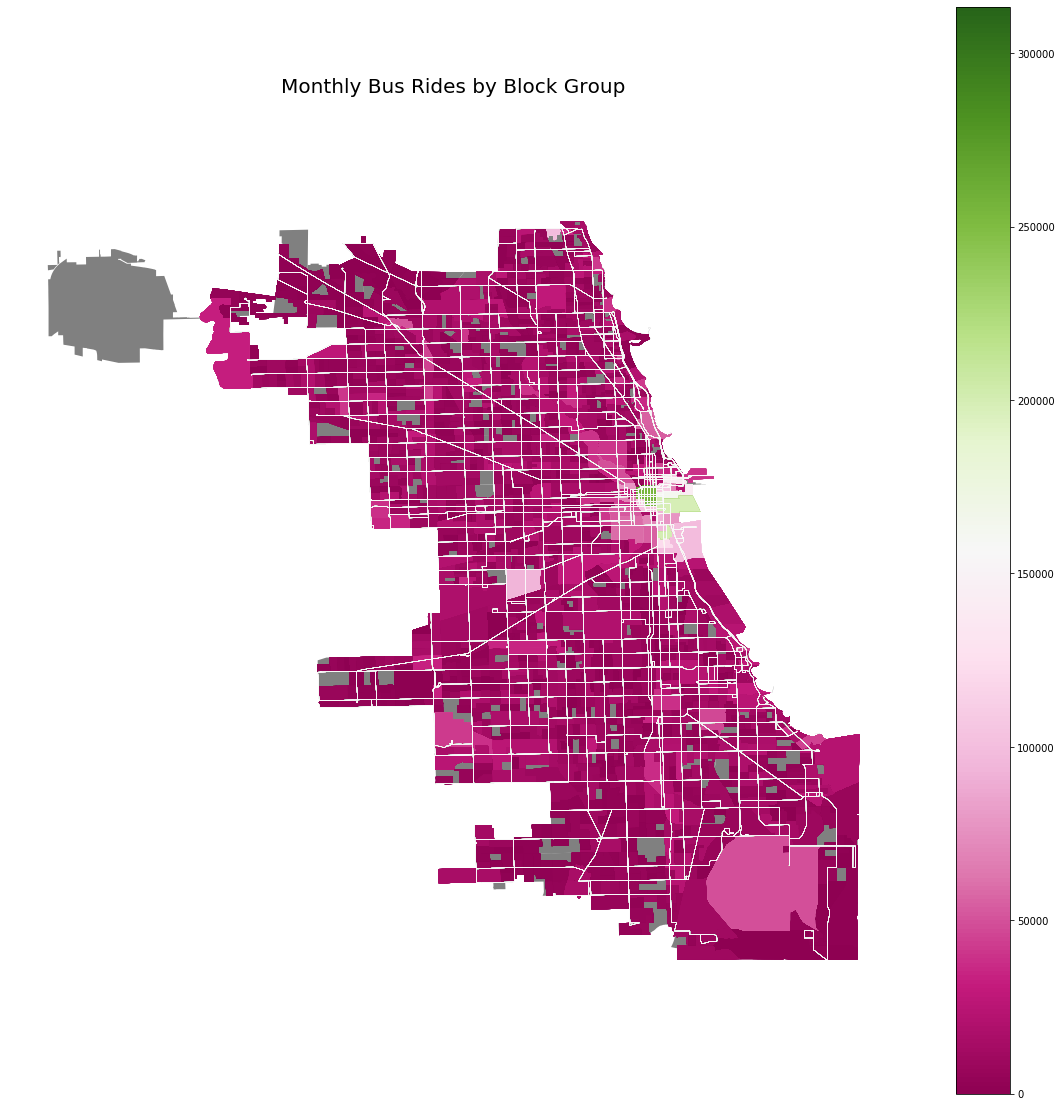

In [88]:
import matplotlib.pyplot as plt

# mapping routes and areas
fig, ax = plt.subplots(figsize=(20, 20))

areas.plot(ax=ax, color="grey")
block_groups.plot(ax=ax, column="MonthTotal", cmap="PiYG", legend=True)
route_rides.plot(ax=ax, linewidth=0.25, color="white", alpha=0.5)

ax.set_axis_off()
ax.set_title("Monthly Bus Rides by Block Group",
             fontdict={"fontsize": 20})

plt.show()

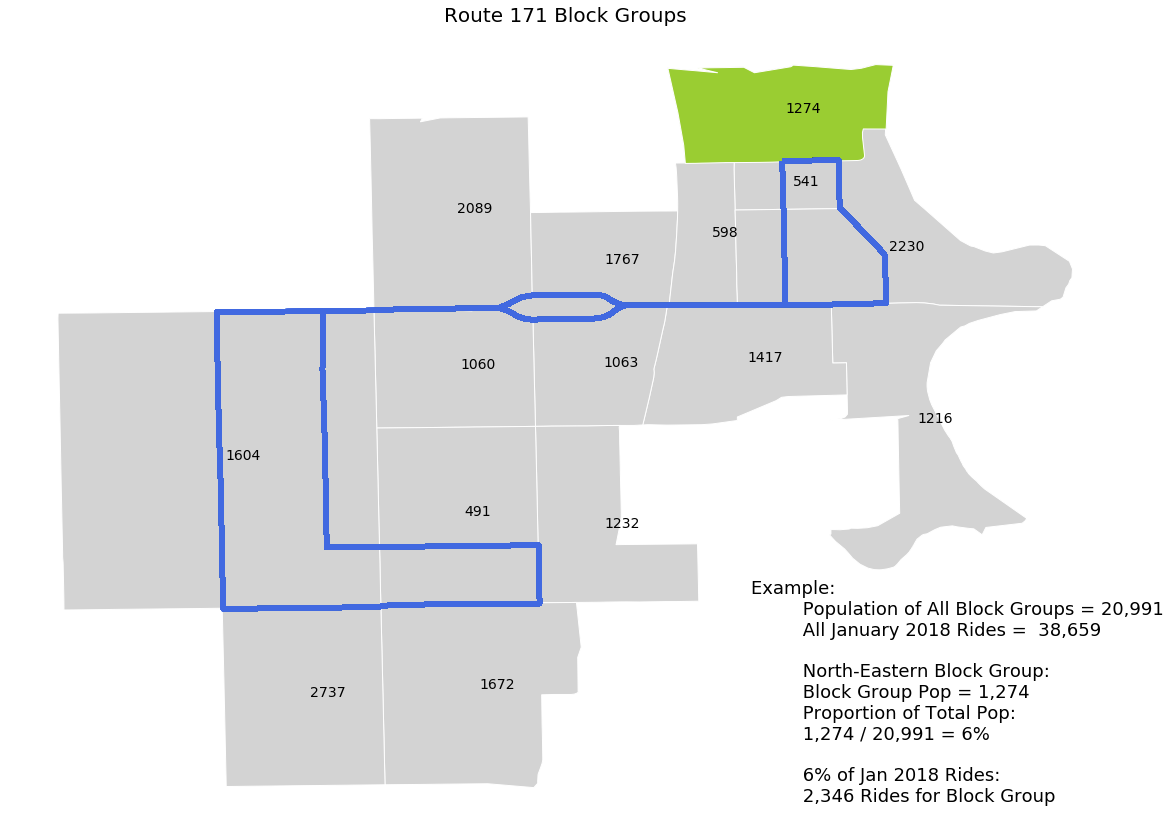

In [117]:
route171_blocks = list(route_blockgroups[(route_blockgroups["route"] == "171") 
                       & (route_blockgroups["year_left"] == 2018)
                       & (route_blockgroups["month"] == 1)]["blockgroup"])

route171_areas = block_groups[(block_groups["year"] == 2018) &
                              (block_groups["month"] == 1) &
                              (block_groups["blockgroup"].isin(route171_blocks))]

# mapping routes and areas
fig, ax = plt.subplots(figsize=(20, 20))

route171_areas.plot(ax=ax, color="lightgray",
                    edgecolor="white")

route171_areas[route171_areas["blockgroup"] == "170314101002"].plot(ax=ax,
                                                                   edgecolor="white",
                                                                   color="yellowgreen")

for row, data in route171_areas[["geometry", "Population"]].iterrows():
    geo, pop = data
    
    ax.text(geo.centroid.x + 0.0002,
            geo.centroid.y,
            pop, fontsize=14)
    
ax.text(-87.585, 41.78,
        "Example: \n \
        Population of All Block Groups = 20,991 \n \
        All January 2018 Rides =  38,659 \n \
        \n \
        North-Eastern Block Group: \n \
        Block Group Pop = 1,274 \n \
        Proportion of Total Pop: \n \
        1,274 / 20,991 = 6% \n \
        \n \
        6% of Jan 2018 Rides: \n \
        2,346 Rides for Block Group",
       fontsize=18)

route_rides[route_rides["route"] == "171"].plot(ax=ax, linewidth=5, color="royalblue")


ax.set_axis_off()
ax.set_title("Route 171 Block Groups",
             fontdict={"fontsize": 20})

plt.show()

In [29]:
block_groups.to_file("data/area_CTA_routes.geojson", driver='GeoJSON')